In [1]:
import sys
wython = '/tigress/wenchang/wython'
TCI = '/tigress/wenchang/analysis/TCI'
if wython not in sys.path:
    sys.path.append(wython)
if TCI not in sys.path:
    sys.path.append(TCI)
from matplotlib import path
import xtc
import cftime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import potential_intensity
from wind_shear import wind_shear
from sklearn.cluster import KMeans
from scipy import stats
from matplotlib.lines import Line2D



precip_sf = 3600*24

In [2]:
precip_ctl = precip_sf*xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.precip.nc')
precip_2x = precip_sf*xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.precip.nc')
tsurf_ctl = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.t_surf.nc')
tsurf_2x = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.t_surf.nc')

In [3]:
v850_ctl = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.v850.nc')
v200_ctl = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.v200.nc')
u850_ctl = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.u850.nc')
u200_ctl = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_tigercpu_intelmpi_18_540PE.atmos_month.u200.nc')
wind_shear_ctl = wind_shear(u850_ctl, v850_ctl, u200_ctl, v200_ctl)

v850_2x = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.v850.nc')
v200_2x = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.v200.nc')
u850_2x = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.u850.nc')
u200_2x = xr.open_dataarray('/tigress/tessj/data/AM2.5.CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.u200.nc')
wind_shear_2x = wind_shear(u850_2x, v850_2x, u200_2x, v200_2x)

In [4]:
omega500_ctl = xr.open_dataarray('/tigress/tessj/data/CTL1990s_v201910_tigercpu_intelmpi_18_540PE.atmos_month.omega.500hPa.nc')
omega500_2x = xr.open_dataarray('/tigress/tessj/data/CTL1990s_v201910_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE.atmos_month.omega.500hPa.nc')                               

In [5]:
from xtc import tc_basins
def tracks_in_basin(ds, basin):
    '''Get the basin bool mask for the tracks dataset.
    **input**:
        ds: tracks dataset;
        basin: basin tag, e.g. "NA" for North Atlantic. 
    **return**:
        in_basin: DataArray of basin mask (bool values)'''
#     ds = xtc.tc_tracks('CTL1860_noleap_tigercpu_intelmpi_18_576PE', years=range(1,11))
#     basin = 'NA'
    # create basin_domain given basin tag, e.g. 'NA' (North Atlantic)
    basins = tc_basins()
    basin_index = basins.map_keys(basin)
    basin_domain = path.Path(basins.coords[basin_index])
    
    # create DataArray of lon/lat pairs
    lon = ds.lon.stack(i_stack=ds.lon.dims)
    lat = ds.lat.stack(i_stack=ds.lat.dims)
    lonlat = xr.concat([lon, lat], dim='lonlat').transpose()
    in_basin = lon.copy().astype('bool') # DataArray to hold the result
    
    # get the basin bool mask for all the tracks
    in_basin.data = basin_domain.contains_points(lonlat)
    in_basin = in_basin.unstack() # unstack to recover the original shape
    
    return in_basin

In [6]:
ds_ctl = xtc.tc_tracks('CTL1990s_tigercpu_intelmpi_18_540PE', model='AM2.5',years=range(101,151))
ds_ctl

years 0101-0150:
101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; year end


<xarray.Dataset>
Dimensions:  (stage: 120, storm: 200, year: 50)
Coordinates:
  * stage    (stage) int64 0 6 12 18 24 30 36 42 ... 678 684 690 696 702 708 714
  * storm    (storm) int64 1 2 3 4 5 6 7 8 9 ... 193 194 195 196 197 198 199 200
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150
Data variables:
    lat      (year, storm, stage) float64 -18.26 -18.8 -19.12 ... nan nan nan
    lon      (year, storm, stage) float64 180.2 180.9 181.3 ... nan nan nan
    windmax  (year, storm, stage) float64 22.67 25.6 25.29 24.08 ... nan nan nan
    slp      (year, storm, stage) float64 984.9 984.6 986.1 ... nan nan nan
    tm       (year, storm, stage) float64 261.6 262.9 260.2 ... nan nan nan
    month    (year, storm, stage) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    day      (year, storm, stage) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    hour     (year, storm, stage) float64 6.0 12.0 18.0 24.0 ... nan nan nan nan

In [7]:
ds_2x = xtc.tc_tracks('CTL1990s_plus2xRegressedLMR2019SST_tigercpu_intelmpi_18_540PE', model='AM2.5',years=range(101,151))
ds_2x

years 0101-0150:
101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; year end


<xarray.Dataset>
Dimensions:  (stage: 120, storm: 200, year: 50)
Coordinates:
  * stage    (stage) int64 0 6 12 18 24 30 36 42 ... 678 684 690 696 702 708 714
  * storm    (storm) int64 1 2 3 4 5 6 7 8 9 ... 193 194 195 196 197 198 199 200
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150
Data variables:
    lat      (year, storm, stage) float64 -18.26 -18.8 -19.12 ... nan nan nan
    lon      (year, storm, stage) float64 180.2 180.9 181.3 ... nan nan nan
    windmax  (year, storm, stage) float64 22.68 25.33 25.58 ... nan nan nan
    slp      (year, storm, stage) float64 984.9 984.5 985.9 ... nan nan nan
    tm       (year, storm, stage) float64 261.7 263.0 260.3 ... nan nan nan
    month    (year, storm, stage) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    day      (year, storm, stage) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    hour     (year, storm, stage) float64 6.0 12.0 18.0 24.0 ... nan nan nan nan

In [8]:
inNA_ctl = tracks_in_basin(ds_ctl, 'NA')
inNA_2x = tracks_in_basin(ds_2x, 'NA')
ds_ctl_NA = ds_ctl.where(inNA_ctl,drop=True)
ds_2x_NA = ds_2x.where(inNA_2x,drop=True)

/home/tessj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using 'Regions_cls' is deprecated, please use 'Regions' instead. Please note that the call signature is different.
  if sys.path[0] == '':


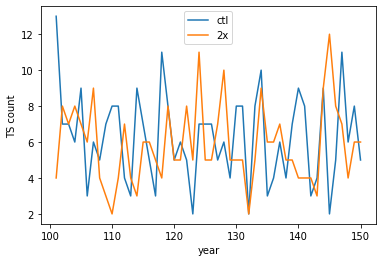

In [9]:
#ts per year = tspy
tspy_ctl_NA = []
for i in ds_ctl_NA.year:
    tspy_ctl_NA.append(len(ds_ctl_NA.sel(year=i).dropna('storm',how='all').storm))
plt.plot(ds_ctl_NA.year,tspy_ctl_NA,label='ctl')
tspy_2x_NA = []
for i in ds_2x_NA.year:
    tspy_2x_NA.append(len(ds_2x_NA.sel(year=i).dropna('storm',how='all').storm))
plt.plot(ds_2x_NA.year,tspy_2x_NA,label='2x')
plt.ylabel('TS count')
plt.xlabel('year')
plt.legend()

In [28]:
(sum(tspy_2x_NA)-sum(tspy_ctl_NA))/sum(tspy_ctl_NA)

-0.06389776357827476

In [9]:
np.mean([a_i - b_i for a_i, b_i in zip(tspy_2x_NA, tspy_ctl_NA)])

-0.4

<xarray.DataArray (year: 50, storm: 92)>
array([[<matplotlib.collections.LineCollection object at 0x7fca47ae1908>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)
Coordinates:
  * storm    (storm) int64 4 7 10 12 14 17 18 20 ... 105 107 108 109 111 113 124
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150

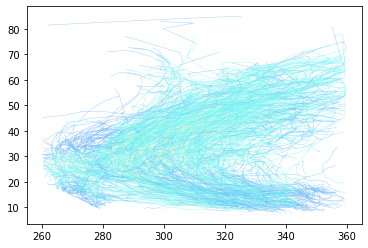

In [13]:
xtc.trackplot(ds_ctl_NA)

<xarray.DataArray (year: 50, storm: 96)>
array([[<matplotlib.collections.LineCollection object at 0x7fca422f6780>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)
Coordinates:
  * storm    (storm) int64 2 3 5 6 9 10 14 16 ... 107 109 110 113 117 118 120
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150

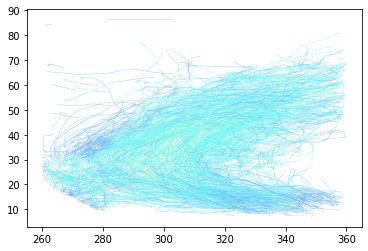

In [36]:
xtc.trackplot(ds_2x_NA)

In [10]:
density_ctl_NA = xtc.tc_density(ds_ctl_NA).mean('time')
density_2x_NA = xtc.tc_density(ds_2x_NA).mean('time')
density_ctl = xtc.tc_density(ds_ctl).mean('time')
density_2x = xtc.tc_density(ds_2x).mean('time')

/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tessj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'TC days per month per 10x10deg box')

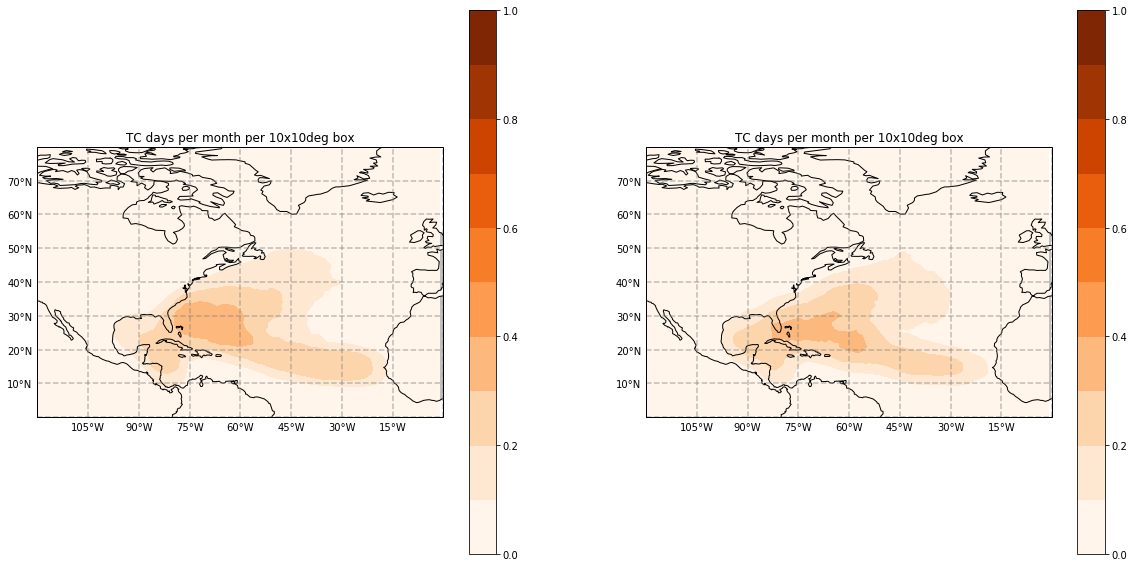

In [12]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
ax1.set_extent([-120,0,0, 80], ccrs.PlateCarree())
density_ctl_NA.plot.contourf(robust=True,cmap='Oranges',vmax=1,levels=11)
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('TC days per month per 10x10deg box')

ax1=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax1.set_extent([-120,0,0, 80], ccrs.PlateCarree())
density_2x_NA.plot.contourf(robust=True,cmap='Oranges',vmax=1,levels=11)
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('TC days per month per 10x10deg box')

Text(0.5, 1.0, '$\\Delta$ TC days per month per 10x10deg box')

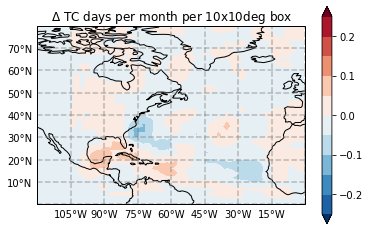

In [15]:
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax1.set_extent([-120,0,0, 80], ccrs.PlateCarree())
(density_2x_NA - density_ctl_NA).plot.contourf(robust=True,cmap='RdBu_r',vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('$\Delta$ TC days per month per 10x10deg box')

Text(0.5, 1.0, '$\\Delta$ TC days per month per 10x10deg box')

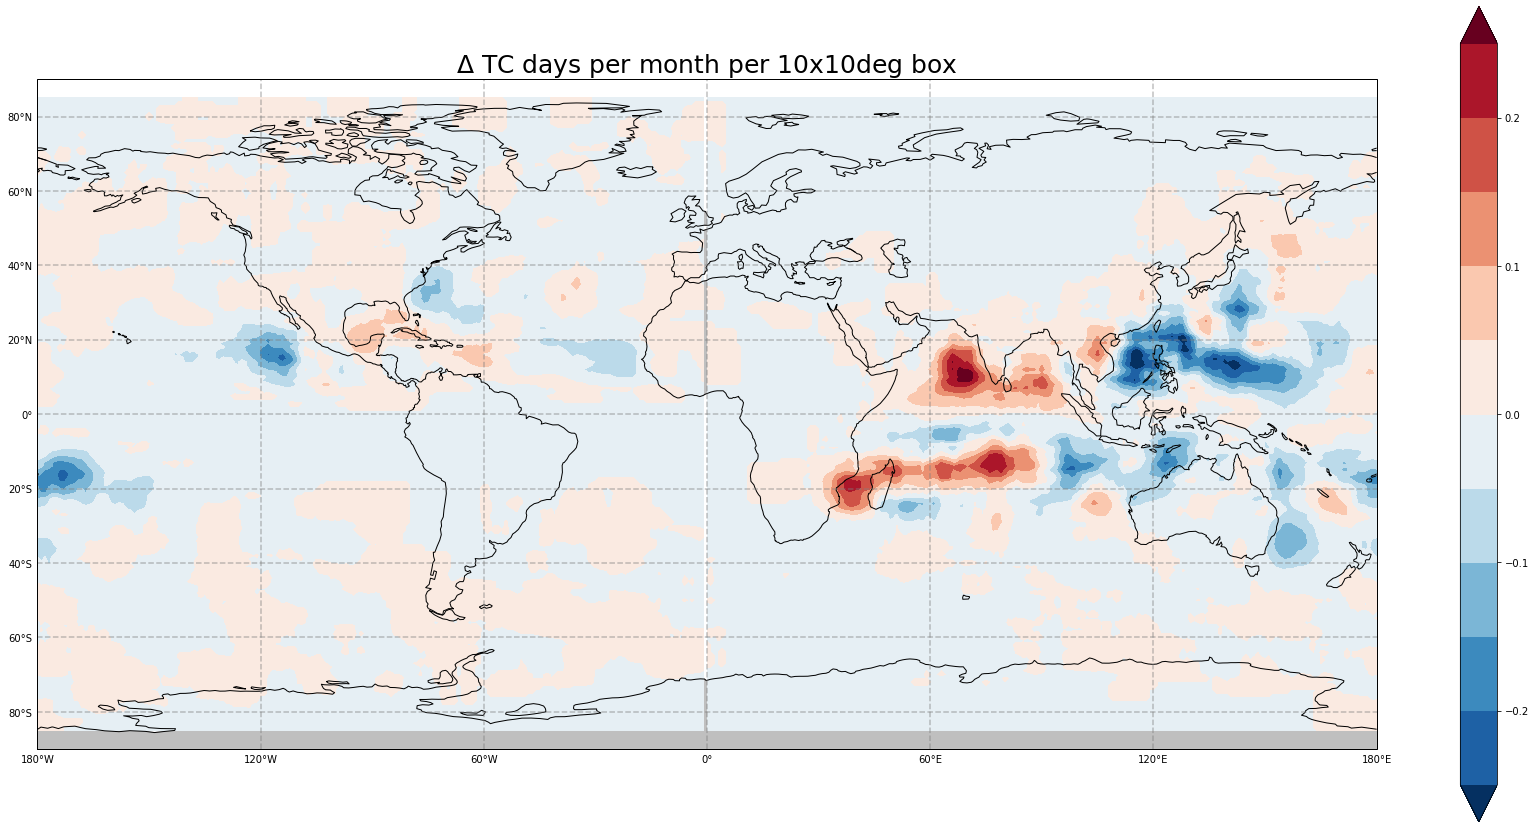

In [14]:
plt.figure(figsize=(30,15))
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
(density_2x - density_ctl).plot.contourf(robust=True,cmap='RdBu_r',vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('$\Delta$ TC days per month per 10x10deg box',fontsize=25)

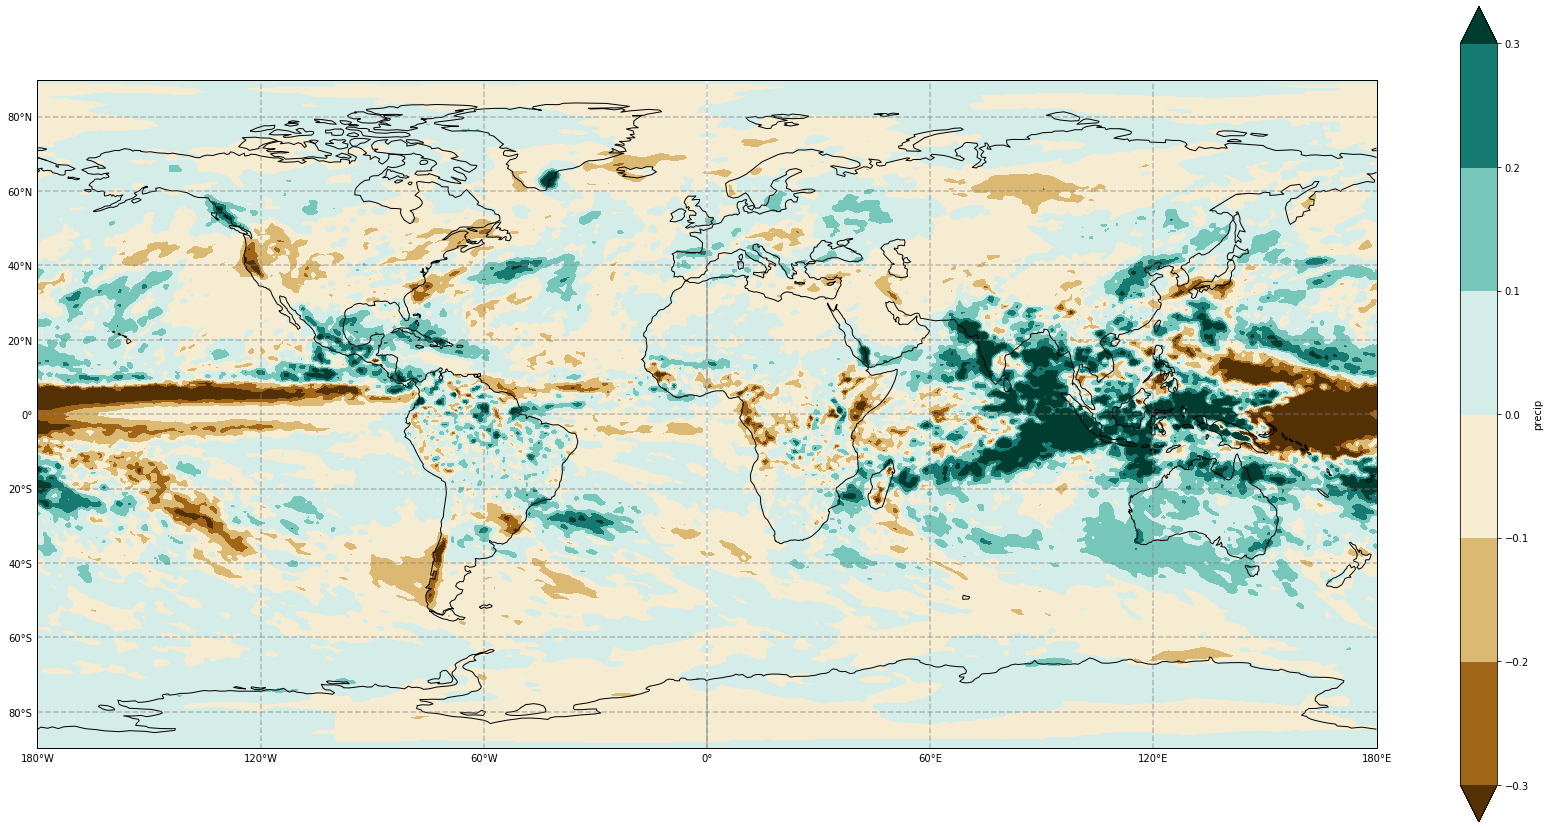

In [24]:
plt.figure(figsize=(30,15))
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
(precip_2x - precip_ctl).mean('time').plot.contourf(robust=True,cmap='BrBG')#,vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()

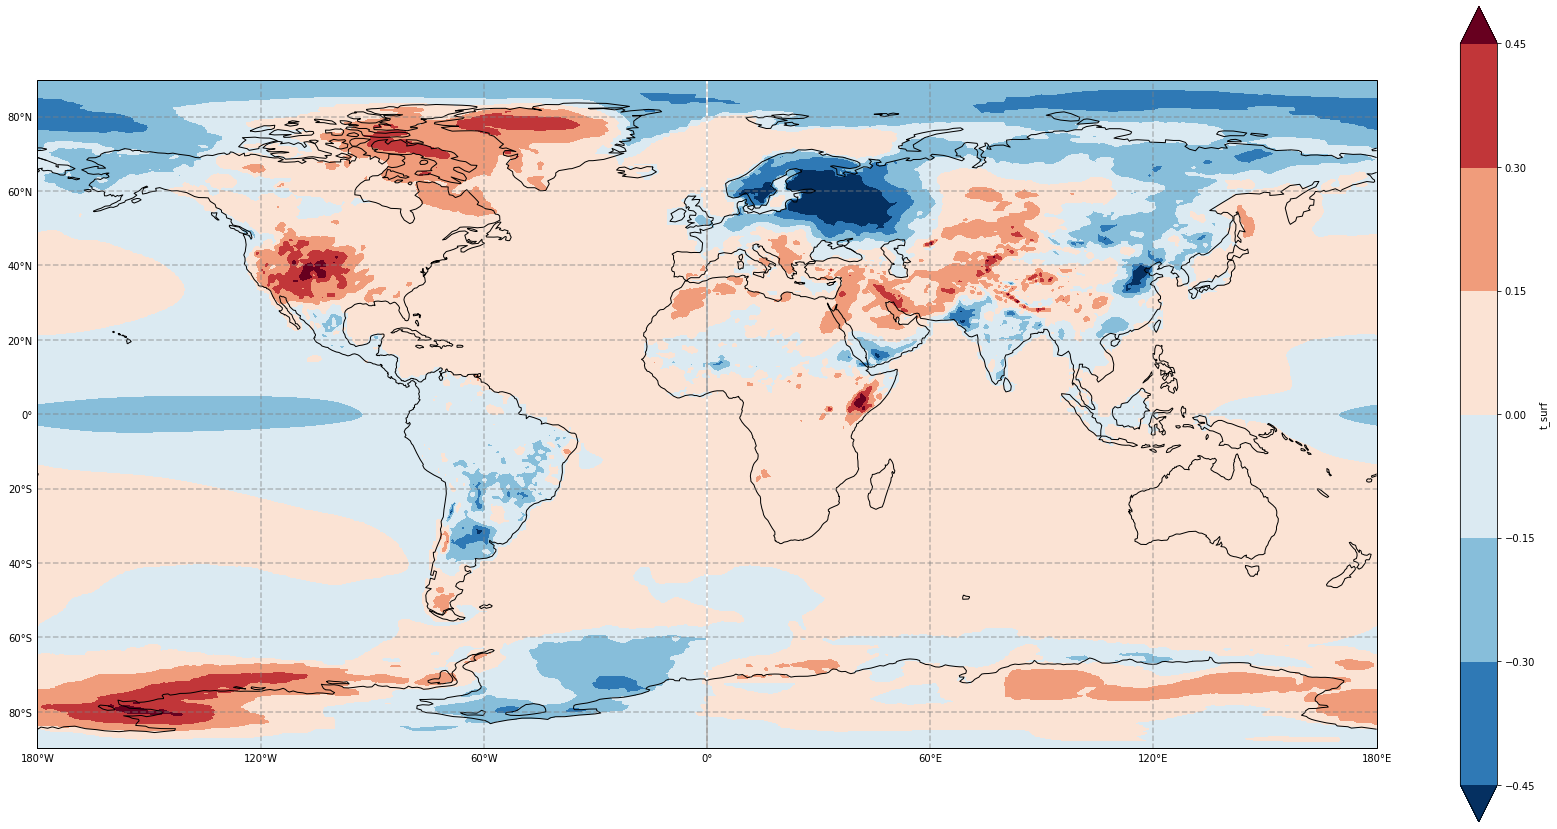

In [25]:
plt.figure(figsize=(30,15))
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
(tsurf_2x - tsurf_ctl).mean('time').plot.contourf(robust=True,cmap='RdBu_r')#,vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()

Text(0.5, 1.0, 'Jun-Nov wind shear anomaly (m/s)')

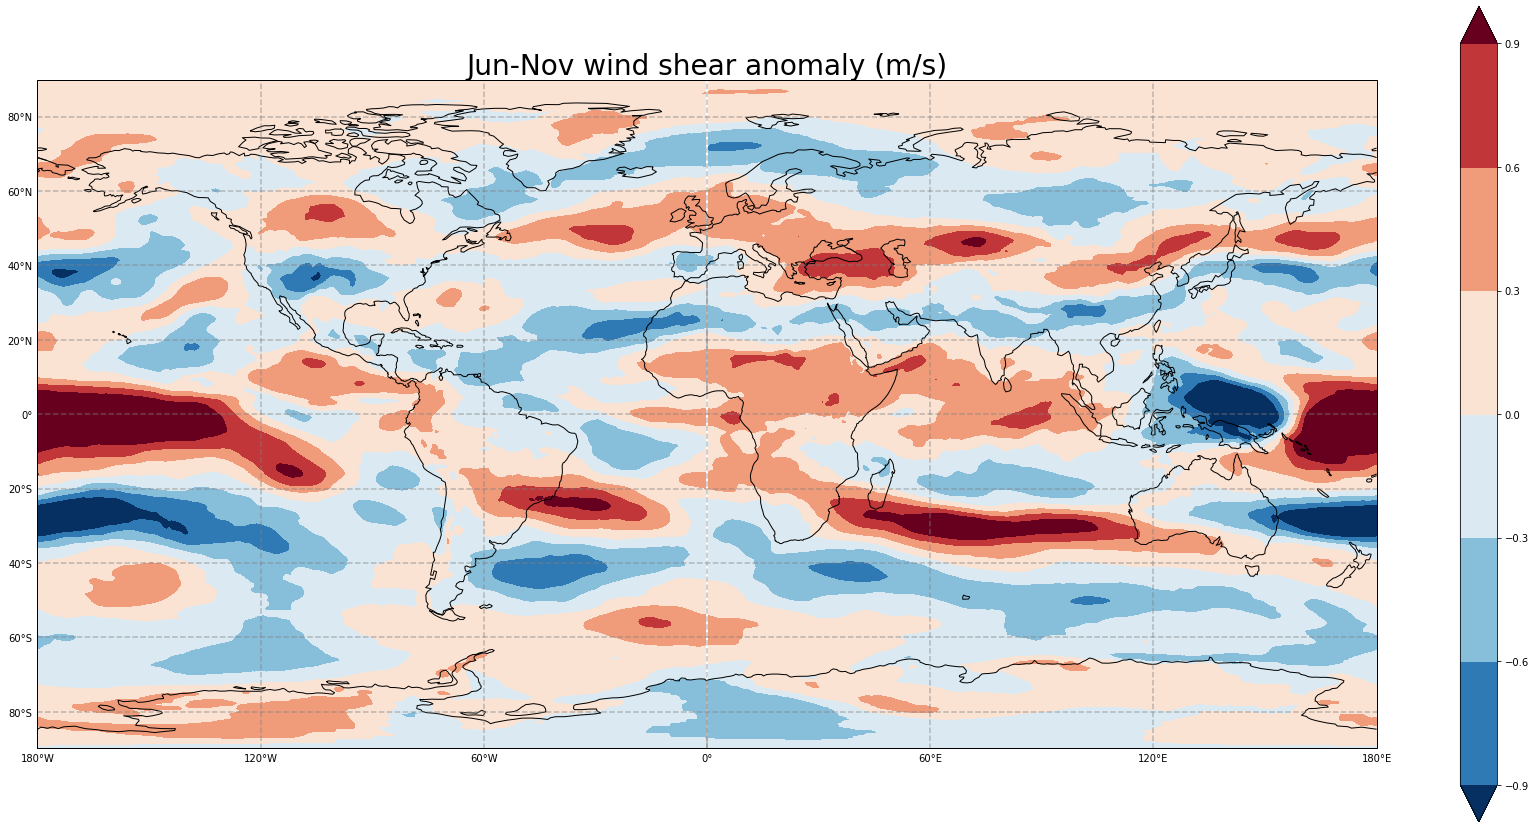

In [27]:
plt.figure(figsize=(30,15))
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
(wind_shear_2x - wind_shear_ctl).groupby('time.month').mean('time').sel(month=[6,7,8,9,10,11]).mean('month').plot.contourf(robust=True,cmap='RdBu_r')#,vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('Jun-Nov wind shear anomaly (m/s)',fontsize=28)

Text(0.5, 1.0, 'Jun-Nov $\\omega_{500hPa}$ anomaly (Pa/s)')

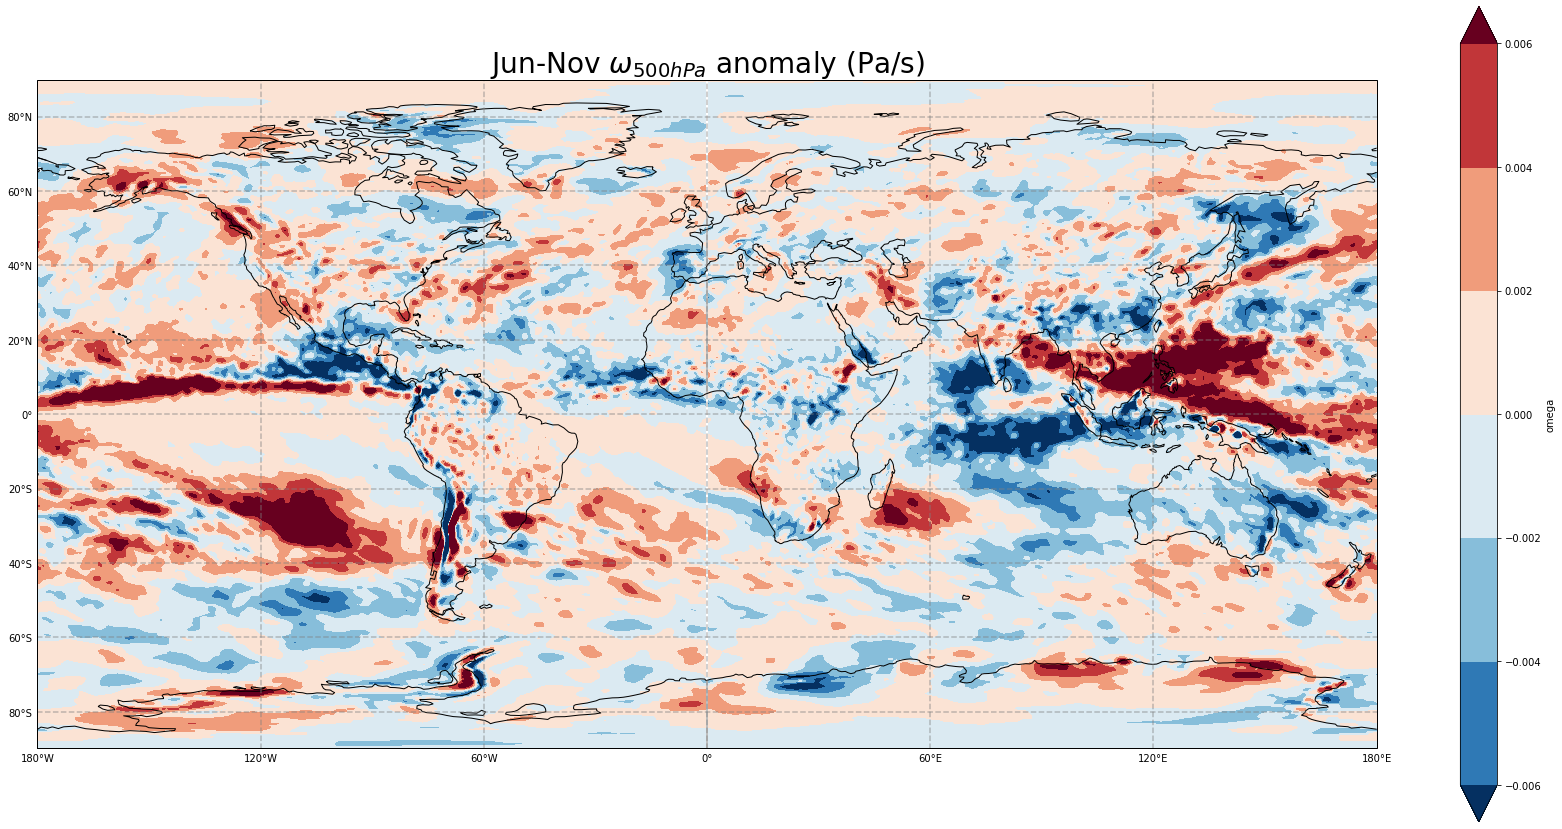

In [17]:
plt.figure(figsize=(30,15))
ax1=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
(omega500_2x - omega500_ctl).groupby('time.month').mean('time').sel(month=[6,7,8,9,10,11]).mean('month').plot.contourf(robust=True,cmap='RdBu_r')#,vmin=-0.25,vmax=0.25,levels=11,extend='both')
ax1.add_feature(cfeature.LAND, facecolor='0.75')
gl=ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax1.coastlines()
ax1.set_title('Jun-Nov $\omega_{500hPa}$ anomaly (Pa/s)',fontsize=28)

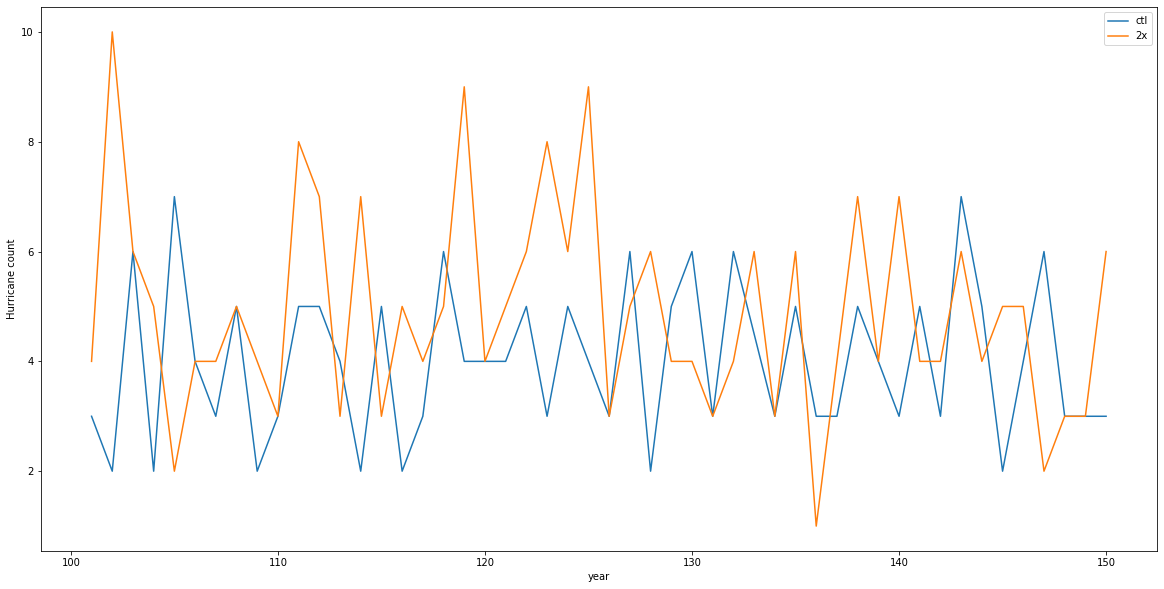

In [127]:
ds_ctl_NA_hur = ds_ctl_NA.where(ds_ctl_NA.windmax>33.,drop=True)
ds_2x_NA_hur = ds_2x_NA.where(ds_2x_NA.windmax>33.,drop=True)

plt.figure(figsize=(20,10))
hpy_ctl_NA = []
for i in ds_ctl_NA_hur.year:
    hpy_ctl_NA.append(len(ds_ctl_NA_hur.sel(year=i).dropna('storm',how='all').storm))
plt.plot(ds_ctl_NA_hur.year,hpy_ctl_NA,label='ctl')
hpy_2x_NA = []
for i in ds_2x_NA_hur.year:
    hpy_2x_NA.append(len(ds_2x_NA_hur.sel(year=i).dropna('storm',how='all').storm))
plt.plot(ds_2x_NA_hur.year,hpy_2x_NA,label='2x')
plt.ylabel('Hurricane count')
plt.xlabel('year')#
plt.legend()

In [29]:
ds_ctl_NA

<xarray.Dataset>
Dimensions:  (stage: 114, storm: 69, year: 50)
Coordinates:
  * stage    (stage) int64 0 6 12 18 24 30 36 42 ... 642 648 654 660 666 672 678
  * storm    (storm) int64 2 4 6 7 8 9 10 11 12 ... 69 70 71 72 74 76 78 81 84
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150
Data variables:
    lat      (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    lon      (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    windmax  (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    slp      (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    tm       (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    month    (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    day      (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan
    hour     (year, storm, stage) float64 nan nan nan nan ... nan nan nan nan

In [49]:
ds_ctl_NA.where(ds_ctl_NA.windmax>=33.).sel(stage=0)


<xarray.Dataset>
Dimensions:  (storm: 92, year: 50)
Coordinates:
    stage    int64 0
  * storm    (storm) int64 4 7 10 12 14 17 18 20 ... 105 107 108 109 111 113 124
  * year     (year) int64 101 102 103 104 105 106 ... 145 146 147 148 149 150
Data variables:
    lat      (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    lon      (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    windmax  (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    slp      (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    tm       (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    month    (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    day      (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan
    hour     (year, storm) float64 nan nan nan nan nan ... nan nan nan nan nan

In [11]:
df_ctl_NA = xr.Dataset.to_dataframe(ds_ctl_NA)
df_2x_NA = xr.Dataset.to_dataframe(ds_2x_NA)


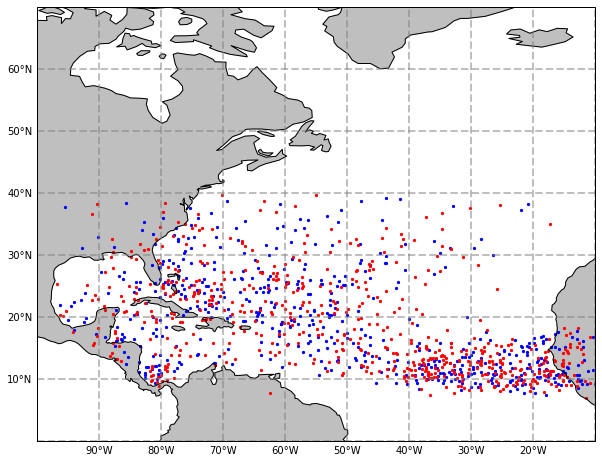

In [90]:
plt.figure(figsize=(10,8))

ax2=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax2.set_extent([-100, -10, 0, 70], ccrs.PlateCarree())

for i in range(len(ds_ctl_NA.year)):
    for ii in range(len(ds_ctl_NA.storm)):
#        if not np.isnan(ds_ctl_NA.isel(year=i,storm=ii).sel(stage=0).lat):
        plt.scatter(ds_ctl_NA.isel(year=i,storm=ii).sel(stage=0).lon,ds_ctl_NA.isel(year=i,storm=ii).sel(stage=0).lat,color='b',s=5,transform=ccrs.PlateCarree())

for i in range(len(ds_2x_NA.year)):
    for ii in range(len(ds_2x_NA.storm)):
#        if not np.isnan(ds_ctl_NA.isel(year=i,storm=ii).sel(stage=0).lat):
        plt.scatter(ds_2x_NA.isel(year=i,storm=ii).sel(stage=0).lon,ds_2x_NA.isel(year=i,storm=ii).sel(stage=0).lat,color='r',s=5,transform=ccrs.PlateCarree())

    
gl=ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
ax2.add_feature(cfeature.LAND, facecolor='0.75')
ax2.coastlines()

In [12]:
'''
# make dataset with vector to cluster by (for this we wanna do locations of: gensis,lysis,and windmax)
count = []
year = []
lats = []
lons = []

#genesis and lysis are indices of the stage of genesis & lysis 
genesis = []
lysis = []
winds = []
lat_gen = []
lon_gen = []
lat_lys = []
lon_lys = []
lat_max = []
lon_max = []
wind_max = []
exp = []
n=1
for i in range(len(ds_ctl_NA.year)):
    for ii in range(len(ds_ctl_NA.storm)):
        if not np.isnan(ds_ctl_NA.isel(year=i,storm=ii).lat).all():
            m=0
            ly=0
            for iii in range(len(ds_ctl_NA.stage)):
                if ((m==0) & (ds_ctl_NA.isel(year=i,storm=ii,stage=iii).windmax.item() >17.) & (ds_ctl_NA.isel(year=i,storm=ii,stage=iii).tm.item() >0.)):
                    genesis.append(iii)
                    m=1
                if ((ds_ctl_NA.isel(year=i,storm=ii,stage=iii).windmax.item() >17.) | (ds_ctl_NA.isel(year=i,storm=ii,stage=iii).tm.item() >0.)):
                    ly=iii
            if m==1:
                lysis.append(ly)
                lat_gen.append(ds_ctl_NA.isel(year=i,storm=ii,stage=genesis[-1]).lat.item())
                lon_gen.append(ds_ctl_NA.isel(year=i,storm=ii,stage=genesis[-1]).lon.item())
                lat_lys.append(ds_ctl_NA.isel(year=i,storm=ii,stage=lysis[-1]).lat.item())
                lon_lys.append(ds_ctl_NA.isel(year=i,storm=ii,stage=lysis[-1]).lon.item())
            #lat_gen.append(lats[-1][0])
            #lon_gen.append(lons[-1][0])
            #lat_lys.append(lats[-1][-1])
            #lon_lys.append(lons[-1][-1])
                count.append(n)
                n+=1
                year.append(ds_ctl_NA.isel(year=i,storm=ii).year.item())
                #lats.append(ds_ctl_NA.isel(year=i,storm=ii).lat.dropna('stage').values.tolist())
                lats.append(ds_ctl_NA.isel(year=i,storm=ii).lat.values.tolist())
                lons.append(ds_ctl_NA.isel(year=i,storm=ii).lon.values.tolist())
                winds.append(ds_ctl_NA.isel(year=i,storm=ii).windmax.values.tolist())
                lat_max.append(lats[-1][np.nanargmax(winds[-1])])
                lon_max.append(lons[-1][np.nanargmax(winds[-1])])
                wind_max.append(max(winds[-1]))
                exp.append('CTL')

for i in range(len(ds_2x_NA.year)):
    for ii in range(len(ds_2x_NA.storm)):
        if not np.isnan(ds_2x_NA.isel(year=i,storm=ii).lat).all():
            m=0
            ly=0
            for iii in range(len(ds_2x_NA.stage)):
                if ((m==0)&(ds_2x_NA.isel(year=i,storm=ii,stage=iii).windmax.item() >17.) & (ds_2x_NA.isel(year=i,storm=ii,stage=iii).tm.item() >0.)):
                    genesis.append(iii)
                    m=1
                if ((ds_2x_NA.isel(year=i,storm=ii,stage=iii).windmax.item() >17.) | (ds_2x_NA.isel(year=i,storm=ii,stage=iii).tm.item() >0.)):
                    ly=iii
            if m==1:
                lysis.append(ly)
                lat_gen.append(ds_2x_NA.isel(year=i,storm=ii,stage=genesis[-1]).lat.item())
                lon_gen.append(ds_2x_NA.isel(year=i,storm=ii,stage=genesis[-1]).lon.item())
                lat_lys.append(ds_2x_NA.isel(year=i,storm=ii,stage=lysis[-1]).lat.item())
                lon_lys.append(ds_2x_NA.isel(year=i,storm=ii,stage=lysis[-1]).lon.item())
            #lat_gen.append(lats[-1][0])
            #lon_gen.append(lons[-1][0])
            #lat_lys.append(lats[-1][-1])
            #lon_lys.append(lons[-1][-1])
                count.append(n)
                n+=1
                year.append(ds_2x_NA.isel(year=i,storm=ii).year.item())
                lats.append(ds_2x_NA.isel(year=i,storm=ii).lat.values.tolist())
                lons.append(ds_2x_NA.isel(year=i,storm=ii).lon.values.tolist())
                winds.append(ds_2x_NA.isel(year=i,storm=ii).windmax.values.tolist())
                lat_max.append(lats[-1][np.nanargmax(winds[-1])])
                lon_max.append(lons[-1][np.nanargmax(winds[-1])])
                wind_max.append(max(winds[-1]))
                exp.append('2X')
                '''
                

In [13]:
'''# make it into a dataarray
index = list(range(0,len(count)))
Count = xr.DataArray(count, coords=[index], dims=['index'])
Lat_gen = xr.DataArray(lat_gen, coords=[index], dims=['index'])
Lon_gen = xr.DataArray(lon_gen, coords=[index], dims=['index'])
Lat_lys = xr.DataArray(lat_lys, coords=[index], dims=['index'])
Lon_lys = xr.DataArray(lon_lys, coords=[index], dims=['index'])
Lat_max = xr.DataArray(lat_max, coords=[index], dims=['index'])
Lon_max = xr.DataArray(lon_max, coords=[index], dims=['index'])
Wind_max = xr.DataArray(wind_max, coords=[index], dims=['index'])
Genesis = xr.DataArray(genesis, coords=[index], dims=['index'])
Lysis = xr.DataArray(lysis, coords=[index], dims=['index'])
Year = xr.DataArray(year, coords=[index], dims=['index'])
Experiment = xr.DataArray(exp, coords=[index], dims=['index'])

all_storms_ds = xr.merge([xr.DataArray(Count, name='Count'), xr.DataArray(Lat_gen, name='Lat_gen'), 
                          xr.DataArray(Lon_gen, name='Lon_gen'), xr.DataArray(Lat_lys, name='Lat_lys'), 
                          xr.DataArray(Lon_lys, name='Lon_lys'), xr.DataArray(Lat_max, name='Lat_max'),
                         xr.DataArray(Lon_max, name='Lon_max'),xr.DataArray(Wind_max, name='Wind_max'),xr.DataArray(Genesis, name='Genesis'),xr.DataArray(Lysis, name='Lysis'),xr.DataArray(Year, name='Year'),xr.DataArray(Experiment, name='Experiment')])

all_storms_ds.to_netcdf('/tigress/tessj/data/AM2.5_CTL1990s_plus2xRegressedLMR2019SST_all_storms.nc')
'''

In [20]:
all_storms_ds = xr.open_dataset('/tigress/tessj/data/AM2.5_CTL1990s_plus2xRegressedLMR2019SST_all_storms.nc')
all_storms_df = xr.Dataset.to_dataframe(all_storms_ds)


In [21]:
#Make a copy of DF
all_storms_df_cp = all_storms_df

#Standardize
clmns = ['Lat_gen', 'Lon_gen','Lat_lys', 'Lon_lys', 'Lat_max', 'Lon_max']
all_storms_df_cp_std = stats.zscore(all_storms_df_cp[clmns])

#Cluster the data
kmeans = KMeans(n_clusters=4, random_state=0).fit(all_storms_df_cp_std)
labels = kmeans.labels_

#Glue back to originaal data
all_storms_df_cp['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

all_storms_df_cp


,Count,Lat_gen,Lon_gen,Lat_lys,Lon_lys,Lat_max,Lon_max,Wind_max,Genesis,Lysis,Year,Experiment,clusters
index,,,,,,,,,,,,,
0,1,22.37,285.22,31.28,268.69,26.09,273.20,25.54,5,26,101,CTL,2
1,2,48.63,327.68,59.24,352.60,52.61,336.45,27.59,13,27,101,CTL,0
2,3,37.51,296.50,55.28,352.61,42.50,316.49,27.27,1,26,101,CTL,0
3,4,23.68,270.55,27.26,260.69,26.90,264.01,24.80,4,33,101,CTL,2
4,5,28.77,273.30,31.50,266.32,28.77,273.30,25.11,8,24,101,CTL,2
5,6,31.70,284.26,59.14,311.37,38.72,296.02,25.69,9,37,101,CTL,3
6,7,24.34,295.52,33.25,310.07,31.25,299.28,25.71,9,45,101,CTL,3
7,8,14.09,281.87,20.86,262.65,20.85,264.10,34.22,6,30,101,CTL,2
8,9,15.29,317.10,37.86,310.09,31.28,307.77,25.07,5,29,101,CTL,1


In [16]:
#separate clusters into their own dataframes
clusters = []
for i in range(4):
    clusters.append(all_storms_df[all_storms_df.clusters==i])

Text(0.5, 0.85, 'AM2.5 C180 CTL + 2xSST hurricane clusters')

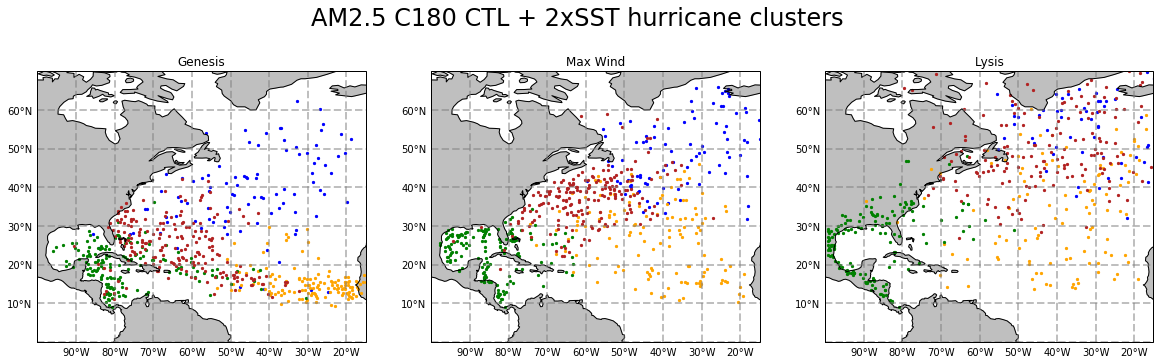

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
titles = ['Genesis','Max Wind', 'Lysis']
colors = ['b','orange','g','firebrick']
varnames = [['Lon_gen','Lat_gen'],['Lon_max','Lat_max'],['Lon_lys','Lat_lys']]

for ii, ax in enumerate(axes.flat):
    ax=plt.subplot(1,3,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-100, -15, 0, 70], ccrs.PlateCarree())
    for i in range(len(clusters)):
        plt.scatter(clusters[i][varnames[ii][0]],clusters[i][varnames[ii][1]],color=colors[i],s=5,transform=ccrs.PlateCarree())
    plt.title(titles[ii])
    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 

plt.suptitle('AM2.5 C180 CTL + 2xSST hurricane clusters',fontsize=24,y=.85)


Text(0.5, 0.98, 'AM2.5 C180 CTL + 2xSST storm clusters')

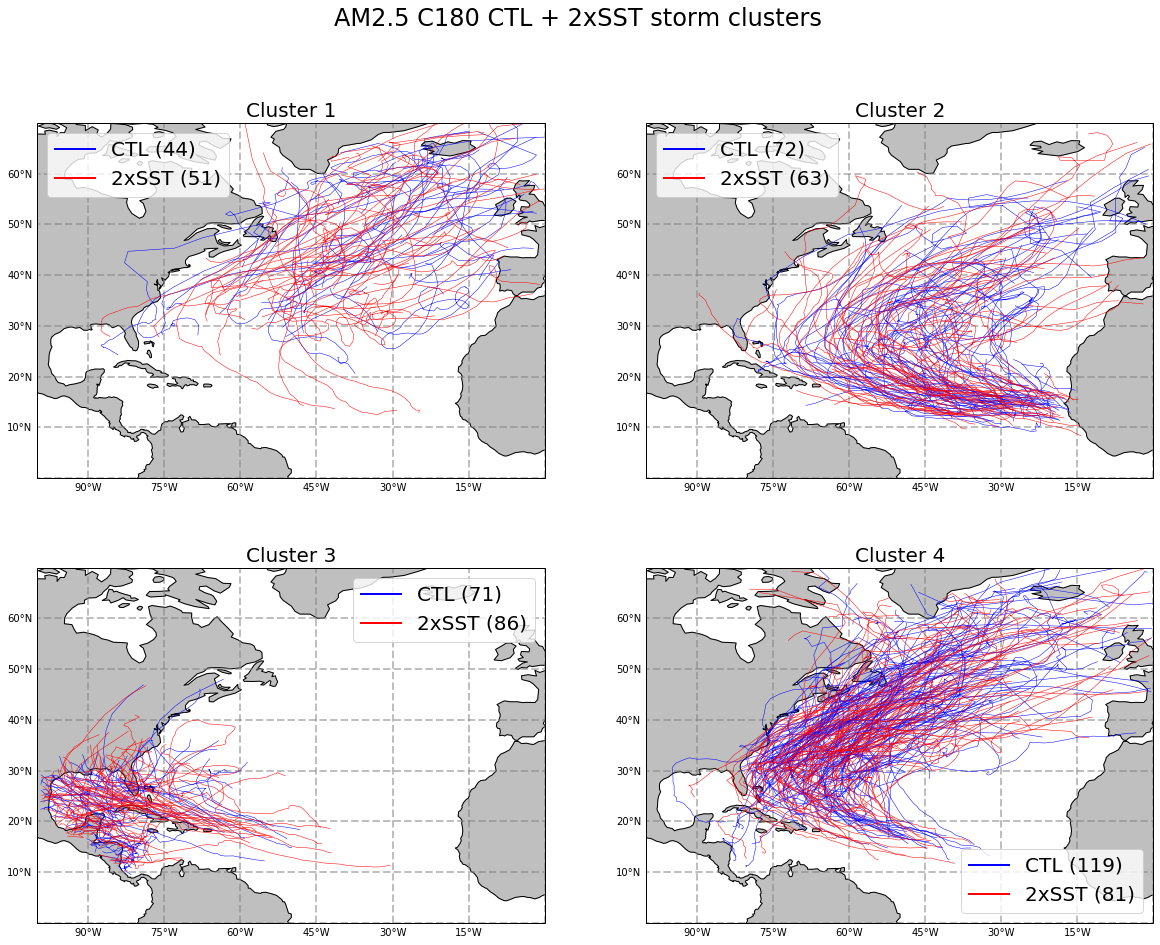

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
titles = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4']
for ii, ax in enumerate(axes.flat):
    n=1
    ax=plt.subplot(2,2,ii+1,projection=ccrs.PlateCarree())
    ax.set_extent([-100, 0, 0, 70], ccrs.PlateCarree())
    for index, row in clusters[ii].iterrows():
        if clusters[ii].Count[index]>n:
            n = clusters[ii].Count[index]
        if clusters[ii].Count[index]==n:
            #single_hur = clusters[ii][clusters[ii].Count==n]
            g = clusters[ii].Genesis[index]
            l = clusters[ii].Lysis[index]
            if clusters[ii].Experiment[index]=='CTL':
                plt.plot(lons[index][g:l+1],lats[index][g:l+1],color='b',transform=ccrs.PlateCarree(),lw=.5)
            else:
                plt.plot(lons[index][g:l+1],lats[index][g:l+1],color='r',transform=ccrs.PlateCarree(),lw=.5)

            n += 1
    plt.title(titles[ii],fontsize=20)
    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND, facecolor='0.75')
    ax.coastlines() 
    custom_lines = [Line2D([0], [0], color='b', lw=2), Line2D([0], [0], color='r', lw=2)]
    ax.legend(custom_lines, [f'CTL (%d)'%len(clusters[ii][clusters[ii].Experiment=='CTL']), f'2xSST (%d)'%len(clusters[ii][clusters[ii].Experiment=='2X'])],fontsize=20)

plt.suptitle('AM2.5 C180 CTL + 2xSST storm clusters',fontsize=24)


In [ ]:
#look at probability of excedence -- this plot looks like prob on y-axis vs #TCs/year 
#wind shear 850 - 200 mbar (magnitude of vector wind difference) June-Nov or Aug-Oct ((u850-u200)^2 + (v850-v200)^2)^0.5
#look at wenchang's scripts for potential intensity, ventillation index
#maybe cluster the NA tracks
#scratch/gpfs2/wenchang/AM2.5_C360
